In [1]:
import sys
sys.path.insert(0, '/home/brysongray/tractography/')

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import os
from collections import deque, namedtuple
import random
import math
from itertools import count


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setup
### Load images

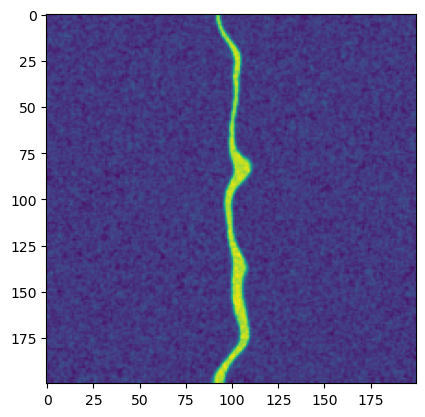

In [2]:
root = '/home/brysongray/tractography/data/synthetic_tracts/'
imglist = os.listdir(root)
img_sample_ids = torch.randint(len(imglist)-1, (len(imglist),))
fnames = list(np.array(os.listdir(root))[img_sample_ids])
vol = []
for i in range(len(fnames)):
    vol.append(torch.from_numpy(np.load(os.path.join(root,fnames[i])).squeeze()))
vol = torch.stack(vol)
plt.figure(0)
plt.imshow(vol[0])

In [3]:
vol.shape

torch.Size([100, 200, 200])

### Create seeds and mask

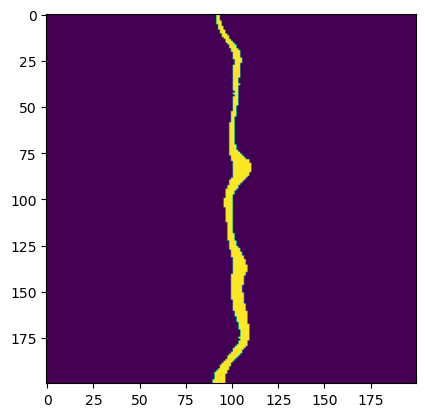

In [4]:
seeds = torch.argwhere(vol[:,-1] > 0.5) # get every (z,x) coordinate at the bottom of the image where the fiber exists
seeds = torch.stack((seeds[:,0], torch.ones(seeds.shape[0])*(vol.shape[1]-1), seeds[:,1]), dim=1) # Put the y coordinate (vol.shape[1]-1) back in. Now each seed is (z,y,x) instead of (z,x).
# We want to choose only one seed per 2D image. We choose randomly.
seeds_ = torch.zeros(vol.shape[0],3)
for i in range(vol.shape[0]):
    seeds_[i] = random.choice(seeds[seeds[:,0]==i])

seeds = seeds_ # seeds is now mx3 where m is number of images
mask = torch.where(vol > 0.5, 1.0, 0.0)
plt.figure(1)
plt.imshow(mask[0])

In [5]:
seeds.shape

torch.Size([100, 3])

### Environment Class

In [5]:
class Environment():
    """ Loads a volume. Takes a list of seeds which
    which will be cycled through on every call of reset.
    """
    def __init__(self, img, pad, seeds, mask, ndim=2, step_size=1):
        self.img = img
        self.pad = pad
        self.seeds = seeds
        self.mask = mask
        self.step_size = step_size
        self.i = 0
        self.position = seeds[self.i].clone()
        self.path = [self.position.clone()+torch.tensor([0.,step_size,0.]), self.position.clone()]
        self.cos_path_angle = [1.0]        

        self.action_space = torch.arange(-torch.pi, torch.pi, torch.pi/32) # using tensor


    def get_state(self):
        z,y,x = self.position.clone().to(int)
        j,i = torch.round(y), torch.round(x) 
        # deal with boundaries
        y_pad_top = y_pad_btm = x_pad_left = x_pad_right = self.pad
        y_zeros_btm = y_zeros_top = x_zeros_left = x_zeros_right = 0
        if (j + self.pad) > self.img.shape[1]-1:
            y_zeros_btm = j + self.pad - (self.img.shape[1]-1) # number of zeros to append in the y dim
            y_pad_btm = self.img.shape[1]-1 - j # remaining distance between y position and the boundary
        if (j - self.pad) < 0:
            y_zeros_top = self.pad - j
            y_pad_top = j
        if (i + self.pad) > self.img.shape[1]-1:
            x_zeros_right = i + self.pad - (self.img.shape[1]-1) # number of zeros to append in the x dim
            x_pad_right = self.img.shape[1]-1 - i # remaining distance between x position and the boundary
        if (i - self.pad) < 0:
            x_zeros_left = self.pad - i
            x_pad_left = i

        state = self.img[z, j-y_pad_top:j+y_pad_btm+1, i-x_pad_left:i+x_pad_right+1].clone()
        state = torch.cat((torch.zeros((y_zeros_top, state.shape[1])), state, torch.zeros((y_zeros_btm, state.shape[1]))), dim=0)
        state = torch.cat((torch.zeros((state.shape[0], x_zeros_left)), state, torch.zeros((state.shape[0], x_zeros_right))), dim=1)
        
        return state.flatten()

    def get_reward(self, terminated, alpha=1.0, beta=1.0, gamma=50):
        if terminated:
            reward = 0
        else:
            in_tract = [1.0 if self.mask[tuple(torch.round(self.position).to(int))] else -10.0][0]
            reward = alpha*in_tract + beta*(self.cos_path_angle[-1]-1) #+ gamma*success
        return torch.tensor([reward], device=device, dtype=torch.float32)

    def step(self, action_id):
        action = self.action_space[action_id.item()]
        # action = self.action_space[action_id] # using tensor
        self.position[1:] = self.position[1:] + torch.tensor([-self.step_size*torch.cos(action), self.step_size*torch.sin(action)])
        self.path.append(self.position.clone())
        prev_step = self.path[-2]-self.path[-3]
        current_step = self.path[-1]-self.path[-2]
        self.cos_path_angle.append(torch.dot(current_step, prev_step).to(float) / self.step_size**2)
        # terminated = any([x >= y or x < 0 for x,y in zip(self.position[1:], self.img.shape[1:])])
        terminated = any([x >= y or x < 0 for x,y in zip(torch.round(self.position[1:]), self.img.shape[1:])]) or len(self.path) > 300
            #or not self.mask[tuple(torch.round(self.position).to(int))]
        if terminated:
            observation = None
            reward = torch.tensor([0.], device=device)
        else:
            observation = self.get_state()
            reward = self.get_reward(terminated, alpha=1.0, beta=1.0)

        return observation, reward, terminated

    def reset(self):
        self.i += 1 if self.i+1 < len(self.seeds) else 0
        self.position = seeds[self.i].clone()
        self.path = [self.position.clone()+torch.tensor([0.0,self.step_size,0.0]), self.position.clone()]
        state = self.get_state()

        return state

### Memory

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Neural Network Setup

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512,128)
        self.layer4 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

### Instantiate environment, target and policy networks, and set hyperparameters

In [8]:
env = Environment(vol, pad=15, seeds=seeds, mask=mask, step_size=2)

In [9]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.001
LR = 1e-4

# Get number of actions
n_actions = len(env.action_space) # scalar
state = env.get_state()

n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True, )
memory = ReplayMemory(10000)


steps_done = 0

def select_action(state, env, prev_action):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # we want a random choice in a certain range around the last step, not too far off.
        # I'll use a subset of them with the previous action at the center.        
        action_subset = []
        current_idx = prev_action.item() - 10
        for i in range(22):
            action_index = current_idx % len(env.action_space)
            action_subset.append(action_index)
            current_idx += 1
        return torch.tensor([[random.choice(action_subset)]], device=device, dtype=torch.long)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            # display.display(plt.gcf())
            display.display(plt.figure(1),display_id=1)
            display.clear_output(wait=True)
        else:
            # display.display(plt.gcf(), display_id=True)
            display.display(plt.figure(1), display_id=1)

episode_return = []

def plot_returns(show_result=False):
    plt.figure(2)
    return_t = torch.tensor(episode_return, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.plot(return_t.numpy())
    # Take 100 episode averages and plot them too
    if len(return_t) >= 100:
        means = return_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            # display.display(plt.gcf())
            display.display(plt.figure(2), display_id=2)
            display.clear_output(wait=True)
        else:
            # display.display(plt.gcf())
            display.display(plt.figure(2), display_id=2)

### Define Model Optimization Function

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward).to(device=device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) # TODO: 

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Train the Network

Complete


<Figure size 640x480 with 0 Axes>

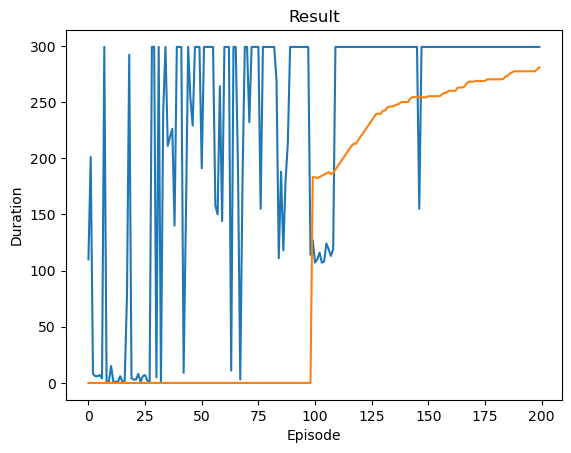

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

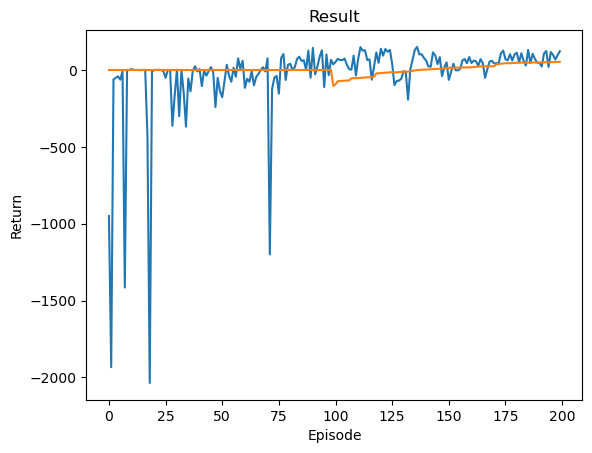

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available():
    num_episodes = 200
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    state = env.reset()
    # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = state.clone().to(dtype=torch.float32, device=device).unsqueeze(0)
    ep_return = 0
    action = torch.tensor([[len(env.action_space)//2]])
    for t in count():
        action = select_action(state, env, action)
        observation, reward, terminated = env.step(action)
        ep_return += reward

        if terminated:
            next_state = None
        else:
            next_state = observation.clone().to(dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episode_durations.append(t + 1)
            episode_return.append(ep_return)
            # plot_durations()
            plot_returns()
            break

print('Complete')
plot_durations(show_result=True)
plot_returns(show_result=True)
plt.ioff()
plt.show()

In [12]:
# plot the path
path = torch.stack(env.path)

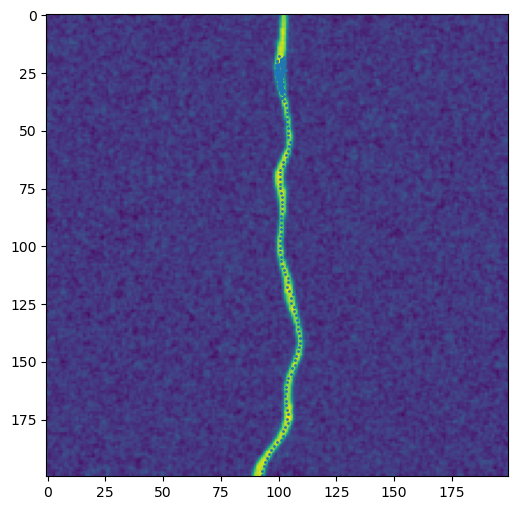

In [13]:
plt.figure(3, figsize=(6,6))
plt.scatter(path[:,2],path[:,1], s=1.0, )
plt.imshow(env.img[env.i])
plt.show()

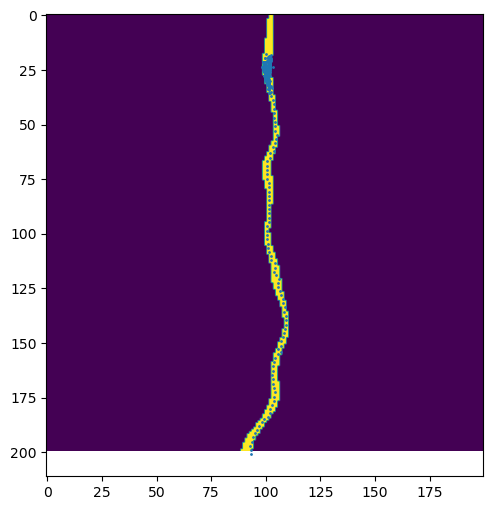

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(env.mask[env.i])
plt.scatter(path[:,2],path[:,1], s=1.0, )
plt.show()

In [160]:
# torch.save(target_net.state_dict(), 'rl_params')

# Run trained network and visualize

In [15]:
env = Environment(vol, pad=15, seeds=seeds, mask=mask, step_size=2)
n_actions = len(env.action_space) # scalar
state = env.get_state()
n_observations = len(state)
trained_net = DQN(n_observations, n_actions).to(device)
trained_state_dict = torch.load('rl_params')
trained_net.load_state_dict(trained_state_dict)
paths = []
for i in range(vol.shape[0]):
    state = env.reset()
    state = state.clone().to(dtype=torch.float32, device=device).unsqueeze(0)
    action = torch.tensor([[len(env.action_space)//2]])
    while True:
        observation, reward, terminated = env.step(action)
        action = trained_net(state).max(1)[1].view(1, 1)

        if terminated:
            paths.append(env.path)
            break
        else:
            next_state = observation.clone().to(dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state


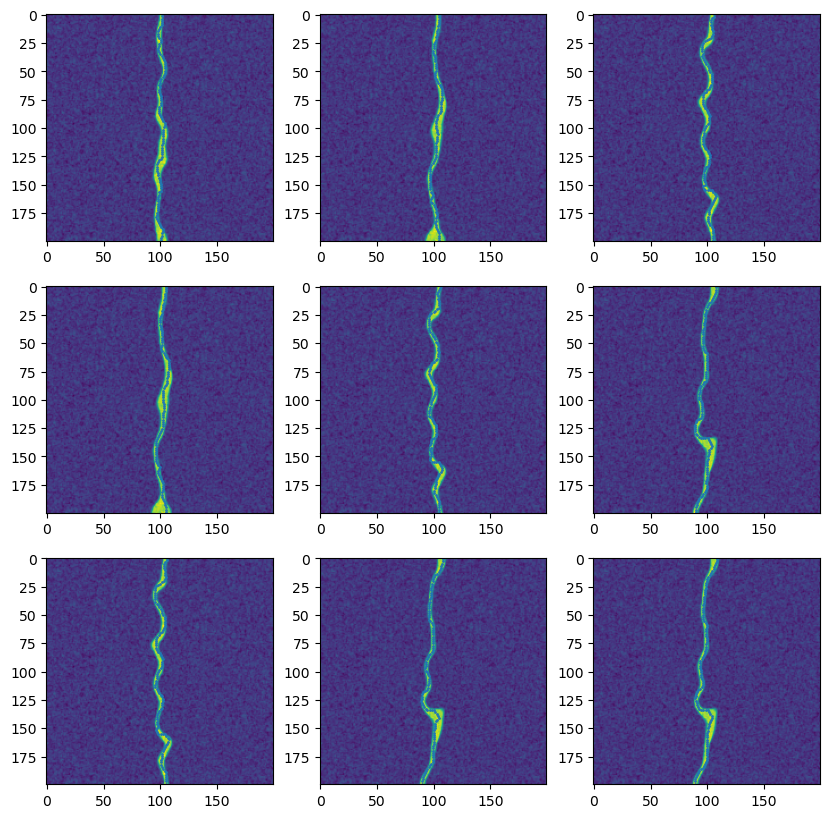

In [16]:
m = 3
n = 3
fig,axs = plt.subplots(m,n,figsize=(10,10))
for i in range(m):
    for j in range(n):
        k = i+j
        path = torch.stack(paths[k])
        axs[i,j].scatter(path[:,2],path[:,1], s=1.0, )
        axs[i,j].imshow(vol[k+1])
plt.show()